In [1]:
%matplotlib inline
import nltk
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wordcloud as wc
from nltk.stem.wordnet import wordnet
from bs4 import BeautifulSoup, NavigableString

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alec\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alec\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Alec\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
def load_soup(filename='Stop Mandatory Vaccination - Posts.html'):
    try:
        return BeautifulSoup(open(filename, encoding='utf-8'))
    except Exception as e:
        print(e)

In [3]:
#Parse a given post's soup and return a dataframe
def parse_post(post_soup, article_div='mbs', article_host_div='_6lz _6mb _1t62 ellipsis', 
               article_subtitle_div='_6m7 _3bt9'):
    data = {}
    data['linked_profiles'] = []
    data['hashtags'] = []
    
    #Get date published
    data['timestamp'] = post_soup.find('abbr').attrs['title']
    
    #Get text and links on the post
    data['links'] = []
    data['text'] = ''
    for p in post_soup.find_all('p'):
        if p.a:
            a_tags = p.a.extract()
            for a_tag in a_tags:
                if not isinstance(a_tag, NavigableString):
                    a_tag = a_tag.text.strip()
                else:
                    a_tag = str(a_tag)
                if a_tag.startswith('#'):
                    data['hashtags'].append(a_tag[1:])
                elif a_tag.startswith('http'):
                    data['links'].append(a_tag)
                else:
                    data['linked_profiles'].append(a_tag)
        data['text'] += p.text
    
    #Find if it has an image or not
    img = post_soup.find('img', {'class': 'scaledImageFitWidth img'})
    data['img_src'] = img.attrs['src'] if img and 'src' in img.attrs else None
    data['img-label'] = img.attrs['aria-label'] if img and 'aria-label' in img.attrs else None
    
    #Get the link info if it exists
    article = post_soup.find('div', class_=article_div)
    data['article_name'] = article.text if article else None
    host = post_soup.find('div', class_=article_host_div)
    data['article_host'] = host.text if host else None
    subtitle = post_soup.find('div', class_=article_subtitle_div)
    data['article_subtitle'] = subtitle.text if subtitle else None
    
    #Find other profiles if it has linked to them
    data['linked_profiles'].extend([page.text for page in post_soup.find_all('span', class_='fwb')
                               if page.text != 'Stop Mandatory Vaccination'])
    
    return data

In [4]:
#Parse all posts given a soup
def parse_posts(soup, limit=0):
    for i, post_child in enumerate(soup.find_all('div', class_='userContent')):
        if limit != 0 and i >= limit:
            break
        yield parse_post(post_child.parent)

In [5]:
#Take a peek at the data
def check_soup(full_soup, limit=3):
    posts = list(parse_posts(full_soup, limit=limit))
    pp = pprint.PrettyPrinter(indent=4, width=110)
    for p in posts:
        pp.pprint(p)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.tokenize import RegexpTokenizer

#Extract features from a dataframe
def extract_features(df, bag_of_words=False, lemmatize=True):
    df['has_article'] = df.article_name.apply(lambda x: x != None)
    df['text_length'] = df.text.apply(len)
    
    df['num_hashtags'] = df.hashtags.apply(len)
    df['has_text'] = df.text_length.apply(lambda x: x > 0)
    df['num_linked_profiles'] = df.linked_profiles.apply(len)
    df['num_links'] = df.links.apply(len)
    
    #Extract nltk features-------------------------------------------------------------
    stop_words = set(nltk.corpus.stopwords.words("english")) #Stop words to not consider
    
    #Tokenize
    df['text_tokenized'] = df.text.apply(nltk.tokenize.word_tokenize)
    df['num_tokens'] = df.text_tokenized.apply(len)
    
    #Tokenize - no punctuations
    no_punc_tokenizer = RegexpTokenizer(r'\w+')
    df['text_tokenized_filtered'] = df.text.apply(
        lambda words: [word.lower() for word in no_punc_tokenizer.tokenize(words) if word not in stop_words])
    
    #Tokenize - lemmatize
    if lemmatize:
        lem = nltk.stem.wordnet.WordNetLemmatizer() #Lemmatize words if possible
        def get_wordnet_pos(pos):
            pos = pos[0].upper()
            wordnet_tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
            return wordnet_tag_dict.get(pos, wordnet.NOUN)
        
        df['text_tokenized_lemmatized'] = df.text_tokenized_filtered.apply(
            lambda words: [lem.lemmatize(word, get_wordnet_pos(pos)) for word, pos in nltk.pos_tag(words)])
    
    #Collect punc info
    df['num_words'] = df.text_tokenized_filtered.apply(len)
    puncs = [('periods', '.'), ('exclamations', '!'), ('questionms', '?'), ('equals', '='), ('dollars', '$')]
    for name, punc in puncs:
        df['num_' + name] = df.text_tokenized.apply(lambda words: words.count(punc))
        df['percent_' + name] = df['num_' + name] / df.num_tokens
        
    #Bag of words model if wanted ---------------------------------------------------
    if bag_of_words:
        count_vectorizer = CountVectorizer()
        tfidf_transformer = TfidfTransformer()
        bag_of_words_matrix = tfidf_transformer.fit_transform(count_vectorizer.fit_transform(df.text))
        return df.to_sparse().join(pd.SparseDataFrame(bag_of_words_matrix, 
                                columns=['word_' + x for x in count_vectorizer.get_feature_names()]))
    return df

In [12]:
#Build a word cloud
def make_wordcloud(text):
    wordcloud = wc.WordCloud(stopwords=wc.STOPWORDS.union({'vaccine', 'vaccinated', 'vaccination', 'vaccinate'}), 
                             background_color='white', width=2100, height=1000).generate(text)
    plt.figure(1, figsize=(21, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [8]:
soup = load_soup()
check_soup(soup, limit=1)

{   'article_host': 'stopmandatoryvaccination.com',
    'article_name': 'Get These Vaccine Books & DVDs Before Amazon Bans Them!',
    'article_subtitle': 'This is where you start, right here, with these excellent resources that medical '
                        'professionals, scientists and activists have created for us so YOU can understand '
                        'this vaccine topic more clearly.',
    'hashtags': [],
    'img-label': 'Amazon Censorship Of Vaccine Books',
    'img_src': './Stop Mandatory Vaccination - '
               'Posts_files/53730872_6120443278387_5582746568928264192_n.png.jpg',
    'linked_profiles': [],
    'links': [],
    'text': 'Get educated. Seriously, read several books and learn and understand this topic inside and out '
            'so you can rebuke the pediatrician, the politician, your friends, your family, and everyone who '
            'may harass you for not vaccinating. And then, get into this fight with us and educate others. '
           

In [9]:
posts = pd.DataFrame(parse_posts(soup))
posts.head(1)

,article_host,article_name,article_subtitle,hashtags,img-label,img_src,linked_profiles,links,text,timestamp
0,stopmandatoryvaccination.com,Get These Vaccine Books & DVDs Before Amazon B...,"This is where you start, right here, with thes...",[],Amazon Censorship Of Vaccine Books,./Stop Mandatory Vaccination - Posts_files/537...,[],[],"Get educated. Seriously, read several books an...","3/3/19, 4:27 PM"


In [10]:
features = extract_features(posts, lemmatize=True)
features.columns

Index(['article_host', 'article_name', 'article_subtitle', 'hashtags',
       'img-label', 'img_src', 'linked_profiles', 'links', 'text', 'timestamp',
       'has_article', 'text_length', 'num_hashtags', 'has_text',
       'num_linked_profiles', 'num_links', 'text_tokenized', 'num_tokens',
       'text_tokenized_filtered', 'text_tokenized_lemmatized', 'num_words',
       'num_periods', 'percent_periods', 'num_exclamations',
       'percent_exclamations', 'num_questionms', 'percent_questionms',
       'num_equals', 'percent_equals', 'num_dollars', 'percent_dollars'],
      dtype='object')

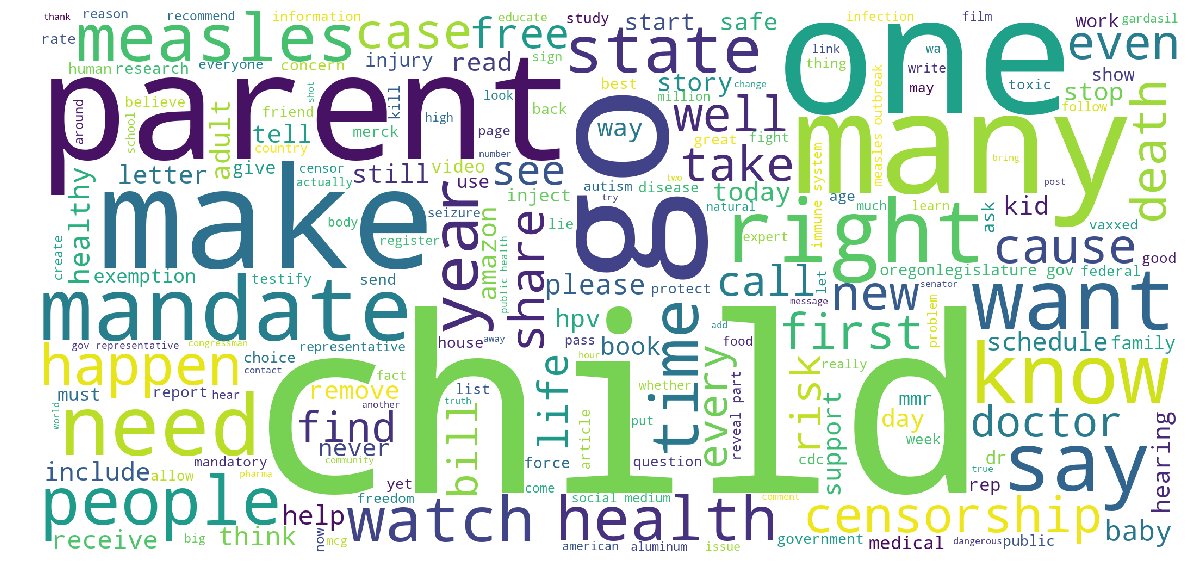

In [13]:
make_wordcloud(' '.join(features.text_tokenized_lemmatized.apply(lambda x: ' '.join(x))))